In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import argrelextrema
from tqdm import tqdm
from itertools import product
from scipy.optimize import linear_sum_assignment

def invert_image(image):
    return 255 - image

# Set rcParams to customize tick labels and spines
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12

# Toy example for the classical Kalman Filter

## Continuous time signals $s_1(t) = cos(t)$ and $s_2(t) = cos(1.4 \cdot t+0.7)$

## Sampling $s(t)$ 

In [4]:
dt = 0.1   # Time step
N = 200    # Number of samples

print('sampling time step dt      =', dt, 's')
print('sampling frequency step df =', 1/dt, 'Hz')
print('N =', N, 'samples')

t = np.arange(0, N * dt, dt)  # Generates n points

# Define 5 signals
s1 = np.cos(t)
s2 = np.sin(1.4*t + 0.7)
# s3 = np.cos(0.8*t - 0.3)
# s4 = np.sin(2*t + 1.2)
# s5 = np.cos(1.2*t + 0.5)

signals = np.array([s1, s2, s3, s4, s5])

# Plot
fig1, ax1 = plt.subplots(2, 1, figsize=(6, 12))

ax1[0].scatter(t, s1, color='r')
ax1[0].set_title('Discrete Time $s_1$')
ax1[0].set_ylabel('Amplitude')
ax1[0].plot(np.linspace(0, N*dt, 1000), np.cos(np.linspace(0, N*dt, 1000)), linestyle='--', color='k')

ax1[1].scatter(t, s2, color='b')
ax1[1].set_title('Discrete Time $s_2$')
ax1[1].set_ylabel('Amplitude')
ax1[1].plot(np.linspace(0, N*dt, 1000), np.sin(1.4*np.linspace(0, N*dt, 1000)+0.7), linestyle='--', color='k')

fig1.tight_layout()
plt.show()


sampling time step dt      = 0.1 s
sampling frequency step df = 10.0 Hz
N = 200 samples


NameError: name 's3' is not defined

## Drawing signal $s$ in a pixel grid to create a raster image

To simplify the process, the image width is set equal to the number of samples in the signals. The signals are then rescaled in amplitude to fit within their assigned band of pixels in the raster image.

In [ ]:
### Parameters

# size of the pixels grid
height = 100
width = 200

# margins
t_margin = 5
l_margin = 0
r_margin = 0
b_margin = 5

line_thickness = 1 # pixels

overlap_percentages = np.linspace(0, 0.3, 5)
###

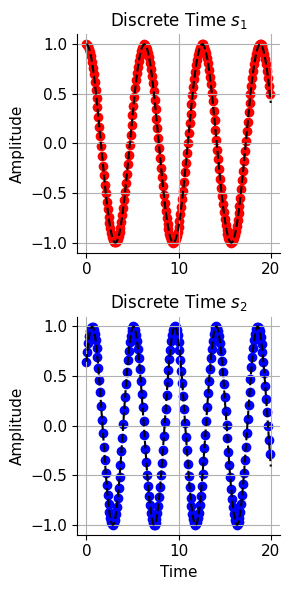

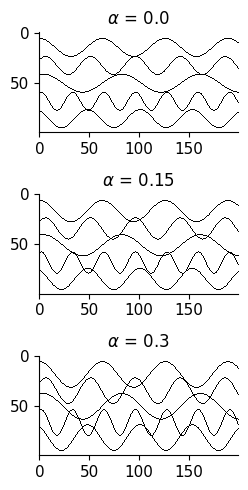

IndexError: list index out of range

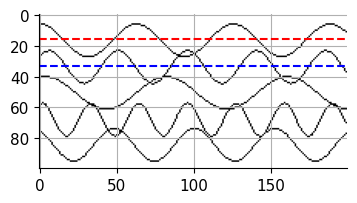

In [ ]:
images = []

# Save the scaled signal as GT for each overlap and for each signal
GTs = np.zeros((len(overlap_percentages), len(signals), N))

for l, overlap_percentage in enumerate(overlap_percentages):
    background = np.full((height, width), 255, dtype=np.int32)  # background of binary image

    num_signals = len(signals)
            
    available_height = height - t_margin - b_margin  # Space available for signals
    max_amplitude = (available_height / num_signals) / (1 - overlap_percentage)  # Control overlap
            
    # Create vertical offsets while considering margins and overlap
    vertical_offsets = np.linspace(t_margin + max_amplitude / 2, height - b_margin - max_amplitude / 2, num_signals)
    if overlap_percentage == overlap_percentages[len(overlap_percentages)//2]:
        vertical_offset = vertical_offsets

    # Horizontal shifting
    available_width = width - l_margin - r_margin
    horizontal_offsets = l_margin
    for i, signal in enumerate(signals):
        # Center, normalize and scale signal
        signal = (signal - np.mean(signal)) / np.max(np.abs(signal))  # Center and normalize
        scaled_signal = (max_amplitude / 2) * signal + vertical_offsets[len(signals)-1-i]  # Rescale amplitude to fit within frame
        # scaled_signal = available_height - scaled_signal
                
        # Create x-coordinates for plotting with horizontal offset
        x_coords = np.linspace(0, available_width - 1, len(signal)).astype(np.int32) + horizontal_offsets
        y_coords = scaled_signal.astype(np.int32)  # Ensure y-coordinates stay in bounds

        # Save GT
        GTs[l, i] =  height-y_coords
                
        # plt.scatter(x_coords, y_coords, color='r')
        # plt.show()

        # Draw 
        for j in range(1, len(x_coords)):
            cv2.line(background, (x_coords[j-1], height-y_coords[j-1]), (x_coords[j], height-y_coords[j]), 0, line_thickness)

    images.append(background)

images = np.array(images)

# Display the images
fig1, ax1 = plt.subplots(2, 1, figsize=(3, 6))

ax1[0].scatter(t, s1, color='r')
ax1[0].set_title('Discrete Time $s_1$')
# ax1[0].set_xlabel('Time')
ax1[0].set_ylabel('Amplitude')
ax1[0].plot(np.linspace(0, N*dt, 1000), np.cos(np.linspace(0, N*dt, 1000)), linestyle='--', color='k')

ax1[1].scatter(t, s2, color='b')
ax1[1].set_title('Discrete Time $s_2$')
ax1[1].set_xlabel('Time')
ax1[1].set_ylabel('Amplitude')
ax1[1].plot(np.linspace(0, N*dt, 1000), np.sin(1.4*np.linspace(0, N*dt, 1000)+0.7), linestyle='--', color='k')

fig1.tight_layout()

# fig1.savefig(f'results/signals_V.pdf', format='pdf', bbox_inches='tight', dpi=300)

fig2, ax2 = plt.subplots(3, 1, figsize=(3, 5))
titles = [overlap_percentages[0], overlap_percentages[len(overlap_percentages)//2], overlap_percentages[-1]]
for i, image in enumerate([images[0], images[len(images)//2], images[-1]]):
    ax2[i].set_title(r'$\alpha$ = ' + str(np.round(titles[i], 3)))
    ax2[i].imshow(image, cmap='gray', vmin=0, vmax=255)
    # ax2[i].axis('off')
    ax2[i].grid(False)
# Show the plot

fig2.tight_layout()
# fig2.savefig(f'results/overlap_v.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# Save images[2] to a pdf file
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(images[len(images)//2], cmap='gray', vmin=0, vmax=255)
# trace horizontal lines 
colors = ['r', 'b']
for i, offset in enumerate(vertical_offset):
    ax.axhline(y=offset, linestyle='--', color=colors[i], label='meanline $s_{}$'.format(i+1))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) 
# ax.axis('off')
fig.savefig('overlap_0.2.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
inverted_images = np.array([invert_image(image) for image in images]) / np.max(images)
all_x_0 = np.array(GTs[:, :, 0]) # Given

# for inverted_image in inverted_images:
#     print(np.where(inverted_image[:, 0] > 1e-16))
    # # find the len(signals) local maxima of inverted_image[:, 0] using argrelextrema
    # min_indices = argrelextrema(inverted_image[:, 0], np.less, order=1)[0]
    # print(min_indices)
    # # sorted_minima = min_indices[np.argsort(inverted_image[min_indices])]

In [ ]:
print(images.shape)

## Evalutate the resulted tracked curves wrt to the GT

In [ ]:
def compute_MSE(estimated_positions, GTs):
    """
    Compute the Mean Squared Error between the estimated positions and the GTs.

    Args:
        estimated_positions (np.ndarray): Shape (M, N) - N estimated positions for M traces.
        GTs (np.ndarray): Shape (M, N) - N GTs for M traces.

    Returns:
        mse (float): MSE for all traces.
    """
    # Compute the MSE between the estimated positions and the GTs
    if len(estimated_positions) != len(GTs):
        raise ValueError('The number of traces in the estimated positions and GTs must be the same.')
    mse = 0
    for i in range(len(GTs)):
        mse += np.mean((estimated_positions[i] - GTs[i])**2)
    return mse / len(GTs)

## Implement the KF on the raster image

### State Transition Model

The state $i$ at time $k$ is defined as
$$
\mathbf{x}^i_k = \begin{bmatrix} p \\ v \end{bmatrix}
$$
where:
- $p$ is the position in the vertical direction.
- $v$ is the velocity in the vertical direction.

Note that the vertical direction corresponds to the vertical axis of the raster image. Moreover, for clarity, the index $i$ will be omitted whenever it does not cause any ambiguity.

The state transition model for a constant velocity motion in 2D is given by:
$$
\mathbf{x}_{k+1} = \mathbf{A} \mathbf{x}_k + \mathbf{w}_k
$$
Where:
- $\mathbf{x}_{k+1}$ is the state at time $k+1$.
- $\mathbf{x}_k$ is the state at time $k$.
- $\mathbf{A} = \begin{bmatrix}
1 & \Delta t \\
0 & 1 \end{bmatrix}$ is the state transition matrix.
- $\mathbf{w}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{Q})$ is the process noise at time $k$.

The measurement model is:
$$
\mathbf{z}_k = \mathbf{H} \mathbf{x}_k + \mathbf{v}_k
$$
Where:
- $\mathbf{z}_k$ is the measurement at time $k$.
- $\mathbf{H} = \begin{bmatrix}
1 & 0 \end{bmatrix}$ is the measurement matrix.
- $\mathbf{v}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{R})$ is the measurement noise at time $k$.

Both $\mathbf{w}_k$ and $\mathbf{v}_k$ are white noise processes.

### Prediction and Update for the Kalman Filter with the Hungarian Algorithm for Measurement-State Association

1. **Prediction Step:**

The prediction step involves predicting the state at time $k+1$ using the state at time $k$ and the state transition model.

- **Predicted state estimate:**
$$
\hat{\mathbf{x}}_{k+1|k} = \mathbf{A} \hat{\mathbf{x}}_{k|k}
$$

- **Predicted covariance estimate:**
$$
\mathbf{P}_{k+1|k} = \mathbf{A} \mathbf{P}_{k|k} \mathbf{A}^T + \mathbf{Q}
$$
Where:
- $\hat{\mathbf{x}}_{k+1|k}$ is the predicted state estimate.
- $\mathbf{P}_{k+1|k}$ is the predicted covariance estimate.
- $\mathbf{P}_{k|k}$ is the current state covariance estimate.

2. **Update Step:**

Once multiple measurements $\mathbf{z}_k$ are available ($M$ in total), the update step corrects the predicted state and covariance by establishing a strict association between the $N$ predicted states and the $M$ measurements. This association problem is optimally solved using the **Hungarian algorithm**, which minimizes the total assignment cost.

**Application of the Hungarian Algorithm**

The Hungarian algorithm is applied to find the best assignment between predicted states and measurements. This is achieved by constructing a **cost matrix** $C$, where each element $C_{ij}$ represents the cost of assigning the $i$-th predicted state to the $j$-th measurement. The cost is typically defined as the Euclidean distance:

$$
C_{ij} = \left| \hat{\mathbf{x}}^i_{k+1|k} - z^j_{k+1} \right|
$$

where $\hat{\mathbf{x}}^i_{k+1|k}$ is the $i$-th predicted position and $z^j_{k+1}$ is the $j$-th measurement.

**Handling Cases Where $M \neq N$**

When the number of measurements $M$ differs from the number of predicted states $N$, the assignment problem must be adapted to handle this imbalance. If $M > N$, meaning there are more measurements than predicted states, some measurements will remain unassigned. Conversely, if $N > M$, meaning there are more predicted states than available measurements, some states would not receive a direct measurement. 

To address this, a **padded cost matrix** is constructed by adding dummy rows or columns, ensuring the matrix becomes square of size $\max(N, M) \times \max(N, M)$. These additional entries represent hypothetical assignments with a high penalty cost, effectively discouraging their selection unless absolutely necessary. The padded cost matrix takes the form:

$$
C_{\text{padded}} =
\begin{bmatrix}
C_{11} & C_{12} & \dots & C_{1M} & P & P & \dots \\
C_{21} & C_{22} & \dots & C_{2M} & P & P & \dots \\
\vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \dots \\
C_{N1} & C_{N2} & \dots & C_{NM} & P & P & \dots \\
P & P & \dots & P & P & P & \dots \\
P & P & \dots & P & P & P & \dots
\end{bmatrix}
$$

where $P$ is a large penalty value that discourages assignments to these artificial entries. The Hungarian algorithm then finds an optimal assignment over this expanded matrix. After the assignment is completed, any pairing involving a dummy row or column is ignored in the final state update. This approach ensures that all valid predicted states are assigned measurements where possible while maintaining a globally optimal assignment strategy.


Once the cost matrix is computed, the Hungarian algorithm solves the assignment problem by finding an optimal set of pairs $(i, j)$ that minimizes the total cost:

$$
\sum_{(i, j) \in \mathcal{A}} C_{ij}
$$

where $\mathcal{A}$ represents the set of assigned state-measurement pairs.

This assignment is then used to update the predicted states. 


- **Innovation covariance and Kalman Gain for each trace:**  

The **innovation covariance** and **Kalman gain** for the $i$-th trace are computed as:

$$
\mathbf{S}_i = \mathbf{H} \mathbf{P}_i \mathbf{H}^T + \mathbf{R}
$$

$$
\mathbf{K}_i = \mathbf{P}_i \mathbf{H}^T \mathbf{S}_i^{-1}
$$

Where:
- $\mathbf{S}_i$ is the innovation covariance for the $i$-th trace.
- $\mathbf{K}_i$ is the Kalman gain for the $i$-th trace.

- **State update using the assigned measurement:**  

Since each predicted state has a unique measurement assigned, the state update follows the standard Kalman filter equations:

$$
\hat{\mathbf{x}}_{k|k} = \hat{\mathbf{x}}_{k|k-1} + \mathbf{K}_i (\mathbf{z}_j - \mathbf{H} \hat{\mathbf{x}}_{k|k-1})
$$

- **Updated covariance estimate:**

$$
\mathbf{P}_{k|k} = (\mathbf{I} - \mathbf{K}_i \mathbf{H}) \mathbf{P}_{k|k-1}
$$

Where:
- $\hat{\mathbf{x}}_{k|k}$ is the updated state estimate.
- $\mathbf{P}_{k|k}$ is the updated covariance estimate.
- $\mathbf{I}$ is the identity matrix.



#### Choice of $\Delta t$

Assuming no corruption of the time axis of the raster image (the horizontal axis), the formula is:
$$ \Delta t = \frac{\text{available\_width}}{N_{\text{samples}} - 1} $$

In our case, $$\Delta t = 1 \quad \text{pixels}$$.

In [ ]:
# Define the prediction step
def predict(X, P, A, Q):
    # check if X has 1 or 2 dimension(s)
    if len(X.shape) == 1:
        X = A @ X
        P = A @ P @ A.T + Q
    else:
        # multiple states in parallel
        for i in range(X.shape[0]):
            X[i] = A @ X[i]
            P[i] = A @ P[i] @ A.T + Q
        # X = (A @ X.T).T  # Batch multiply all rows of X at once
        # P = A @ P @ A.T + Q  # Assuming P is (N, M, M), use batch multiplication
    return X, P

def update(x, P, z, H, R):
    if len(x.shape) == 1:
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
        x = x + K @ (z - H @ x)
        P = P - K @ H @ P
    else:
        for i in range(x.shape[0]):
            S = H @ P[i] @ H.T + R
            K = P[i] @ H.T @ np.linalg.inv(S)
            x[i] = x[i] + K @ (z[i] - H @ x[i])
            P[i] = P[i] - K @ H @ P[i]
    return x, P

In [ ]:
# Simulated Measurements from True Trajectories
def generate_measurements(true_positions, num_measurements, noise_std=0.5):
    replace = num_measurements > len(true_positions)  # Handle cases where M > N
    if replace:
        indices_0 = np.random.choice(len(true_positions), len(true_positions), replace=False)
        indices_1 = np.random.choice(len(true_positions), num_measurements - len(true_positions), replace=True)
        indices = np.concatenate([indices_0, indices_1])
    else:
        indices = np.random.choice(len(true_positions), num_measurements, replace=replace)  # Select M random measurements
    return true_positions[indices] + np.random.normal(0, noise_std, size=(num_measurements,))


# Compute Cost Matrix (Euclidean Distance)
def compute_cost_matrix(predicted_positions, measurements):
    cost_matrix = np.abs(predicted_positions[:, None] - measurements[None, :])
    return cost_matrix

### Find good parameters

In [ ]:
### 
# Classical Kalman filter with the Hungarian algorithm
###

### Parameters
Dts = [0.01] # np.linspace(0.01, 5, 3) # Time step related to the state transition matrix A, ! different than sampling rate dt of signal s

# Assuming no process noise
sigma_ps = [0.0001] # np.linspace(1e-4, 2, 3) 
sigma_vs = [2.0] # np.linspace(1e-4, 2, 3)
sigma_as = [0.0001] # np.linspace(1e-4, 2, 3)
# Assuming no measurement noise
sigma_zs = [1e-6] # np.linspace(1e-6, 1, 3)

###

# Select an overlap percentage
sel = 0 #len(overlap_percentages)//2

min_MSE = np.inf
best_params = {}
best_result = None

for Dt in tqdm(Dts, desc='Dt'):
    for sigma_p in sigma_ps:
        for sigma_v in sigma_vs:
            for sigma_z in sigma_zs:
                for sigma_a in sigma_as:
                    for sel, overlap_percentage in enumerate(overlap_percentages):

                        A = np.array([[1, Dt, Dt**2/2], 
                                    [0, 1, Dt],
                                    [0, 0, 1]]).astype(np.float64)
                        
                        H = np.array([[1, 0, 0]]).astype(np.float64)

                        Q = np.array([[sigma_p**2, 0, 0],
                                    [0, sigma_v**2, 0],
                                    [0, 0, sigma_a**2]])

                        R = np.array([[sigma_z**2]])

                        # Initial state covariance given all_x_0
                        P = np.zeros((3, 3))
                        P[1, 1] = 10
                        P[2, 2] = 10  

                        x_0 = all_x_0[1]
                        X_weighted = np.array([[x_0[0], 0, 0], [x_0[1], 0, 0]]).astype(np.float64)
                        P_weighted = np.array([np.copy(P), np.copy(P)]).astype(np.float64)

                        tresh = 1e-2

                        image = inverted_images[sel]

                        avg_N_components = 2

                        estimated_positions_weighted = [[] for _ in range(avg_N_components)] # shape (N_components, N)
                        estimated_positions_weighted[0].append(X_weighted[0, 0])
                        estimated_positions_weighted[1].append(X_weighted[1, 0])

                        for k in range(1, image.shape[1]):
                            col = image[:, k]
                            # find the non 0 value pixels, with a given treshold
                            measurements = (np.where(col > tresh)[0]).astype(np.float64)
                            print(measurements)
                            M = len(measurements)
                            if M == 0:
                                # Predict
                                X_w, P_w = predict(X_weighted, P_weighted, A, Q)
                                for i in range(avg_N_components):
                                    # Save the estimated position
                                    estimated_positions_weighted[i].append(X_w[i, 0])
                                continue

                            # Predict
                            X_w, P_w = predict(X_weighted, P_weighted, A, Q)
                            # print("X", X_w.shape, "measurements", measurements.shape)
                            cost_matrix = compute_cost_matrix(X_w[:, 0], measurements)
                            # print("cost_matrix", cost_matrix.shape)

                            # TODO: Implement the Hungarian algorithm
                            # Handle cases where M != N by padding the cost matrix
                            max_dim = max(avg_N_components, M)
                            padded_cost_matrix = np.full((max_dim, max_dim), np.max(cost_matrix) + 999999999)  # Large penalty for unassigned
                            padded_cost_matrix[:avg_N_components, :M] = cost_matrix
                            
                            row_ind, col_ind = linear_sum_assignment(padded_cost_matrix)
                            
                            # Update
                            X_weighted = np.copy(X_w)
                            P_weighted = np.copy(P_w)
                            for i, j in zip(row_ind, col_ind):
                                if i < avg_N_components and j < M:  # Ignore padded assignments
                                    X_weighted[i], P_weighted[i] = update(X_weighted[i], P_weighted[i], measurements[j], H, R)
                                    
                            for i in range(avg_N_components):
                                # Save the estimated position
                                estimated_positions_weighted[i].append(X_weighted[i, 0])

                        # Compute MSE for the weighted Kalman filter

                        MSE = compute_MSE(estimated_positions_weighted, GTs[sel])
                    if MSE < min_MSE:
                        min_MSE = MSE
                        best_params = {'Dt': Dt, 'sigma_p': sigma_p, 'sigma_v': sigma_v, 'sigma_a': sigma_a, 'sigma_z': sigma_z}
                        best_result = estimated_positions_weighted

print('Best parameters:', best_params)
print('Minimum MSE:', min_MSE)

# plot the best estimated positions
plt.imshow(images[sel], cmap='gray', vmin=0, vmax=255)
plt.scatter(np.arange(0, len(best_result[0])), best_result[0], color='r', s=3)
plt.scatter(np.arange(0, len(best_result[1])), best_result[1], color='b', s=3)
plt.title(r'overlap $\alpha = $'+ overlap_percentage.astype(str))
plt.show()

Dt: 100%|██████████| 3/3 [00:30<00:00, 10.17s/it]
Best parameters: {'Dt': 0.01, 'sigma_p': 0.0001, 'sigma_v': 2.0, 'sigma_a': 0.0001, 'sigma_z': 1e-06}
Minimum MSE: 0.9675000010239675

### Evaluate the method for different degrees of overlap

In [ ]:
print(image.shape)

In [ ]:


for sel, overlap_percentage in tqdm(enumerate(overlap_percentages), desc='Overlap percentage'):
    
    P = np.zeros((3, 3))
    P[1, 1] = 50
    P[2, 2] = 50

    x_0 = all_x_0[1]
    X_weighted = np.array([[x_0[0], 0, 0], [x_0[1], 0, 0]]).astype(np.float64)
    P_weighted = np.array([np.copy(P), np.copy(P)]).astype(np.float64)

    tresh = 1e-2
    image = inverted_images[sel]
    avg_N_components = 2

    # ---------- Store all states and stds ----------
    estimated_positions_weighted = [[] for _ in range(avg_N_components)]
    estimated_velocities_weighted = [[] for _ in range(avg_N_components)]
    estimated_accelerations_weighted = [[] for _ in range(avg_N_components)]

    std_positions_weighted = [[] for _ in range(avg_N_components)]
    std_velocities_weighted = [[] for _ in range(avg_N_components)]
    std_accelerations_weighted = [[] for _ in range(avg_N_components)]

    for i in range(avg_N_components):
        estimated_positions_weighted[i].append(X_weighted[i, 0])
        estimated_velocities_weighted[i].append(X_weighted[i, 1])
        estimated_accelerations_weighted[i].append(X_weighted[i, 2])

        std_positions_weighted[i].append(np.sqrt(P_weighted[i][0, 0]))
        std_velocities_weighted[i].append(np.sqrt(P_weighted[i][1, 1]))
        std_accelerations_weighted[i].append(np.sqrt(P_weighted[i][2, 2]))

    for k in range(1, image.shape[1]):
        col = image[:, k]
        measurements = (np.where(col > tresh)[0]).astype(np.float64)
        M = len(measurements)

        X_w, P_w = predict(X_weighted, P_weighted, A, Q)

        if M > 0:
            cost_matrix = compute_cost_matrix(X_w[:, 0], measurements)
            max_dim = max(avg_N_components, M)
            padded_cost_matrix = np.full((max_dim, max_dim), np.max(cost_matrix) + 999999999)
            padded_cost_matrix[:avg_N_components, :M] = cost_matrix

            row_ind, col_ind = linear_sum_assignment(padded_cost_matrix)

            X_weighted = np.copy(X_w)
            P_weighted = np.copy(P_w)
            for i, j in zip(row_ind, col_ind):
                if i < avg_N_components and j < M:
                    X_weighted[i], P_weighted[i] = update(X_weighted[i], P_weighted[i], measurements[j], H, R)
        else:
            X_weighted = X_w
            P_weighted = P_w

        # Save state and std at each step
        for i in range(avg_N_components):
            estimated_positions_weighted[i].append(X_weighted[i, 0])
            estimated_velocities_weighted[i].append(X_weighted[i, 1])
            estimated_accelerations_weighted[i].append(X_weighted[i, 2])

            std_positions_weighted[i].append(np.sqrt(P_weighted[i][0, 0]))
            std_velocities_weighted[i].append(np.sqrt(P_weighted[i][1, 1]))
            std_accelerations_weighted[i].append(np.sqrt(P_weighted[i][2, 2]))

    # -------------------- PLOT ----------------------

    t = np.arange(len(estimated_positions_weighted[0]))
    colors = ['r', 'b']

    # Position plot with Ground Truth (in black, no label)
    plt.figure(figsize=(8, 5))

    # Plot ground truths (in black)
    for i in range(avg_N_components):
        gt = np.array(GTs[sel][i])
        plt.plot(t, gt, color='k', linewidth=1)

    # Plot estimated trajectories with uncertainties
    for i in range(avg_N_components):
        pos = np.array(estimated_positions_weighted[i])
        std = np.array(std_positions_weighted[i])
        plt.scatter(t, pos, color=colors[i], s=8, label=f'Component {i+1}')
        plt.fill_between(t, pos - 3*std, pos + 3*std, color=colors[i], alpha=0.2)

    plt.title(f'Position | Overlap={overlap_percentage:.2f}')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (pixels)')
    plt.legend()
    plt.show()

    # Velocity plot
    plt.figure(figsize=(8, 5))
    for i in range(avg_N_components):
        vel = np.array(estimated_velocities_weighted[i])
        std = np.array(std_velocities_weighted[i])
        plt.plot(t, vel, color=colors[i], label=f'Component {i+1}')
        plt.fill_between(t, vel - 3*std, vel + 3*std, color=colors[i], alpha=0.2)
    plt.title(f'Velocity | Overlap={overlap_percentage:.2f}')
    plt.legend()
    plt.show()

    # Acceleration plot
    plt.figure(figsize=(8, 5))
    for i in range(avg_N_components):
        acc = np.array(estimated_accelerations_weighted[i])
        std = np.array(std_accelerations_weighted[i])
        plt.plot(t, acc, color=colors[i], label=f'Component {i+1}')
        plt.fill_between(t, acc - 3*std, acc + 3*std, color=colors[i], alpha=0.2)
    plt.title(f'Acceleration | Overlap={overlap_percentage:.2f}')
    plt.legend()
    plt.show()


Overlap percentage: 0it [00:00, ?it/s]


NameError: name 'all_x_0' is not defined